This tutorial and the assets can be downloaded as part of the [Wallaroo Tutorials repository](https://github.com/WallarooLabs/Wallaroo_Tutorials/blob/wallaroo2024.1_tutorials/wallaroo-observe-tutorials/edge-observability-assays).

## Wallaroo Run Anywhere Model Drift Observability with Assays: Preparation

The Model Insights feature lets you monitor how the environment that your model operates within may be changing in ways that affect it's predictions so that you can intervene (retrain) in an efficient and timely manner. Changes in the inputs, **data drift**, can occur due to errors in the data processing pipeline or due to changes in the environment such as user preference or behavior. 

Wallaroo Run Anywhere allows models to be deployed on edge and other locations, and have their inference result logs uploaded to the Wallaroo Ops center.  Wallaroo assays allow for model drift detection to include the inference results from one or more deployment locations and compare any one or multiple locations results against an established baseline.

This notebook is designed to demonstrate the Wallaroo Run Anywhere with Model Drift Observability with Wallaroo Assays.  This notebook will walk through the process of:


* **Preparation**:  This notebook focuses on setting up the conditions for model edge deployments to different locations.  This includes:
  * Setting up a workspace, pipeline, and model for deriving the price of a house based on inputs.
  * Performing a sample set of inferences to verify the model deployment.
  * Publish the deployed model to an Open Container Initiative (OCI) Registry, and use that to deploy the model to two difference edge locations.
* **Model Drift by Location**:
  * Perform inference requests on each of the model edge deployments.
  * Perform the steps in creating an assay:
    * Build an assay baseline with a specified location for inference results.
    * Preview the assay and show different assay configurations based on selecting the inference data from the Wallaroo Ops model deployment versus the edge deployment.
    * Create the assay.
    * View assay results.

This notebook focuses on **Model Drift by Location**.

## Goal

Model insights monitors the output of the house price model over a designated time window and compares it to an expected baseline distribution. We measure the performance of model deployments in different locations and compare that to the baseline to detect model drift.

### Resources

This tutorial provides the following:

* Models:
  * `models/rf_model.onnx`: The champion model that has been used in this environment for some time.
  * Various inputs:
    * `smallinputs.df.json`: A set of house inputs that tends to generate low house price values.
    * `biginputs.df.json`: A set of house inputs that tends to generate high house price values.

### Prerequisites

* A deployed Wallaroo instance with [Edge Registry Services](https://docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-configuration/wallaroo-edge-deployment/#enable-wallaroo-edge-deployment-registry) and [Edge Observability enabled](https://docs.wallaroo.ai/wallaroo-operations-guide/wallaroo-configuration/wallaroo-edge-deployment/#set-edge-observability-service).
* The following Python libraries installed:
  * [`wallaroo`](https://pypi.org/project/wallaroo/): The Wallaroo SDK. Included with the Wallaroo JupyterHub service by default.
  * [`pandas`](https://pypi.org/project/pandas/): Pandas, mainly used for Pandas DataFrame
* A X64 Docker deployment to deploy the model on an edge location.
* The notebook "Wallaroo Run Anywhere Model Drift Observability with Assays: Preparation" has been run, and the model edge deployments executed.

## Steps

* Deploying a sample ML model used to determine house prices based on a set of input parameters.
* Build an assay baseline from a set of baseline start and end dates, and an assay baseline from a numpy array.
* Preview the assay and show different assay configurations.
* Upload the assay.
* View assay results.
* Pause and resume the assay.

This notebook **requires** the notebook "Wallaroo Run Anywhere Model Drift Observability with Assays: Preparation" has been run, and the model edge deployments executed.  The name of the workspaces, pipelines, and edge locations in this notebook **must** match the same ones in "Wallaroo Run Anywhere Model Drift Observability with Assays: Preparation".

### Import Libraries

The first step will be to import our libraries, and set variables used through this tutorial.

In [1]:
import wallaroo
from wallaroo.object import EntityNotFoundError
from wallaroo.framework import Framework

from IPython.display import display

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

import datetime
import time
import json

workspace_name = f'run-anywhere-assay-demonstration-tutorial'
main_pipeline_name = f'assay-demonstration-tutorial'
model_name_control = f'house-price-estimator'
model_file_name_control = './models/rf_model.onnx'

# Set the name of the assay
assay_name="ops assay example"
edge_assay_name = "edge assay example"
combined_assay_name = "combined assay example"

# ignoring warnings for demonstration
import warnings
warnings.filterwarnings('ignore')

# used to display DataFrame information without truncating
from IPython.display import display
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [2]:
def get_workspace(name, client):
    workspace = None
    for ws in client.list_workspaces():
        if ws.name() == name:
            workspace= ws
    return workspace

### Connect to the Wallaroo Instance

The first step is to connect to Wallaroo through the Wallaroo client.  The Python library is included in the Wallaroo install and available through the Jupyter Hub interface provided with your Wallaroo environment.

This is accomplished using the `wallaroo.Client()` command, which provides a URL to grant the SDK permission to your specific Wallaroo environment.  When displayed, enter the URL into a browser and confirm permissions.  Store the connection into a variable that can be referenced later.

If logging into the Wallaroo instance through the internal JupyterHub service, use `wl = wallaroo.Client()`.  For more information on Wallaroo Client settings, see the [Client Connection guide](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-client/).

In [3]:
# Login through local Wallaroo instance

wl = wallaroo.Client()

### Retrieve Workspace and Pipeline

For our example, we will retrieve the same workspace and pipeline that were used to create the edge locations.  This requires that the preparation notebook is run first @TODO: name and file name of the notebook.

In [5]:
workspace = get_workspace(workspace_name, wl)

wl.set_current_workspace(workspace)

### List Pipeline Edges

The pipeline published in the notebook ""Wallaroo Run Anywhere Model Drift Observability with Assays: Preparation" created two edge locations.

We start by retrieving the pipeline, then verifying the pipeline publishes with the `wallaroo.pipeline.publishes()` methods.

We then list the edges with the `wallaroo.pipeline.list_edges` methods.  This verifies the names of our edge locations, which are used later in the model drift detection by location methods.

In [6]:
mainpipeline = wl.build_pipeline(main_pipeline_name)

# list the publishes

display(mainpipeline.publishes())

# get the edges

display(mainpipeline.list_edges())

id,pipeline_version_name,engine_url,pipeline_url,created_by,created_at,updated_at
11,fa48cea1-77ba-4035-b2d3-65a76b6aa10b,us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/engines/proxy/wallaroo/ghcr.io/wallaroolabs/fitzroy-mini:v2024.1.0-main-4609,us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/pipelines/assay-demonstration-tutorial:fa48cea1-77ba-4035-b2d3-65a76b6aa10b,john.hummel@wallaroo.ai,2024-28-Feb 17:10:25,2024-28-Feb 17:10:25
12,d8beac00-0eac-424b-a2d8-26396d274e5e,us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/engines/proxy/wallaroo/ghcr.io/wallaroolabs/fitzroy-mini:v2024.1.0-main-4609,us-central1-docker.pkg.dev/wallaroo-dev-253816/uat/pipelines/assay-demonstration-tutorial:d8beac00-0eac-424b-a2d8-26396d274e5e,john.hummel@wallaroo.ai,2024-28-Feb 18:04:15,2024-28-Feb 18:04:15


ID,Name,Tags,SPIFFE ID
d7573f61-2f06-4355-a080-618f74b3032d,houseprice-edge-demo-01,[],wallaroo.ai/ns/deployments/edge/d7573f61-2f06-4355-a080-618f74b3032d
34e56e04-b8b1-479c-b20f-817b72e35963,houseprice-edge-demo-02,[],wallaroo.ai/ns/deployments/edge/34e56e04-b8b1-479c-b20f-817b72e35963
5641d1c7-8a06-4697-b95a-8a13f00f3024,houseprice-edge-demonstration-01,[],wallaroo.ai/ns/deployments/edge/5641d1c7-8a06-4697-b95a-8a13f00f3024
0efdddad-be50-40b1-8f90-32a9a159249c,houseprice-edge-demonstration-02,[],wallaroo.ai/ns/deployments/edge/0efdddad-be50-40b1-8f90-32a9a159249c


### Historical Data via Edge Inferences Generation

We will perform sample inference on our edge location.  This historical inference data is used later in the drift detection by location examples.

For these example, the edge location is on the hostname `HOSTNAME`.  Change this hostname to the host name of your edge deployment.

We will submit two sets of inferences:

* A normal set of inferences to generate the baseline, and are unlikely to trigger an assay alert when compared against the baseline.  These are run through the location `houseprice-edge-01`.
* A set of inferences that will return large house values that is likely to trigger an assay alert when compared against the baseline.  These are run through the location `houseprice-edge-02`.

In [9]:
assay_baseline_start = datetime.datetime.now()

time.sleep(65)

small_houses_inputs = pd.read_json('./data/smallinputs.df.json')
baseline_size = 500

# These inputs will be random samples of small priced houses.  Around 500 is a good number
small_houses = small_houses_inputs.sample(baseline_size, replace=True).reset_index(drop=True)
# small_houses.to_dict(orient="records")
data = small_houses.to_dict(orient="records")

!curl -X POST HOSTNAME:8081/pipelines/{main_pipeline_name} \
    -H "Content-Type: Content-Type: application/json; format=pandas-records" \
    --data '{json.dumps(data)}'

assay_baseline_end = datetime.datetime.now()

time.sleep(65)

# set the start of the assay window period
assay_window_start = datetime.datetime.now()

# generate a set of normal house values
!curl -X POST HOSTNAME:8081/pipelines/{main_pipeline_name} \
    -H "Content-Type: Content-Type: application/json; format=pandas-records" \
    --data @./data/normal-inputs.df.json


[{"time":1709226560554,"in":{"tensor":[2.0,1.0,800.0,1200.0,2.0,0.0,0.0,3.0,7.0,800.0,0.0,47.6968994141,-122.3470001221,806.0,1200.0,15.0,0.0,0.0]},"out":{"variable":[404484.44]},"anomaly":{"count":0},"metadata":{"last_model":"{\"model_name\":\"house-price-estimator\",\"model_sha\":\"e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6\"}","pipeline_version":"fa48cea1-77ba-4035-b2d3-65a76b6aa10b","elapsed":[2491631,1084114],"dropped":[],"partition":"houseprice-edge-demonstration-01"}},{"time":1709226560554,"in":{"tensor":[3.0,2.0,1400.0,7384.0,1.0,0.0,0.0,3.0,7.0,1150.0,250.0,47.4654998779,-122.1740036011,1820.0,7992.0,35.0,0.0,0.0]},"out":{"variable":[267013.94]},"anomaly":{"count":0},"metadata":{"last_model":"{\"model_name\":\"house-price-estimator\",\"model_sha\":\"e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6\"}","pipeline_version":"fa48cea1-77ba-4035-b2d3-65a76b6aa10b","elapsed":[2491631,1084114],"dropped":[],"partition":"houseprice-edge-demonstratio

In [11]:
# set of values for the second edge location

time.sleep(65)

# generate a set of normal house values
!curl -X POST HOSTNAME2:8081/pipelines/{main_pipeline_name} \
    -H "Content-Type: Content-Type: application/json; format=pandas-records" \
    --data @./data/normal-inputs.df.json

time.sleep(65)
# generate a set of large house values that will trigger an assay alert based on our baseline
large_houses_inputs = pd.read_json('./data/biginputs.df.json')
baseline_size = 500

# These inputs will be random samples of small priced houses.  Around 500 is a good number
large_houses = large_houses_inputs.sample(baseline_size, replace=True).reset_index(drop=True)
data = large_houses.to_dict(orient="records")

!curl -X POST HOSTNAME2:8081/pipelines/{main_pipeline_name} \
    -H "Content-Type: Content-Type: application/json; format=pandas-records" \
    --data '{json.dumps(data)}'

[{"time":1709226892593,"in":{"tensor":[4.0,2.5,2900.0,5505.0,2.0,0.0,0.0,3.0,8.0,2900.0,0.0,47.6063,-122.02,2970.0,5251.0,12.0,0.0,0.0]},"out":{"variable":[718013.75]},"anomaly":{"count":0},"metadata":{"last_model":"{\"model_name\":\"house-price-estimator\",\"model_sha\":\"e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6\"}","pipeline_version":"fa48cea1-77ba-4035-b2d3-65a76b6aa10b","elapsed":[4515045,3118730],"dropped":[],"partition":"houseprice-edge-demonstration-02"}},{"time":1709226892593,"in":{"tensor":[2.0,2.5,2170.0,6361.0,1.0,0.0,2.0,3.0,8.0,2170.0,0.0,47.7109,-122.017,2310.0,7419.0,6.0,0.0,0.0]},"out":{"variable":[615094.56]},"anomaly":{"count":0},"metadata":{"last_model":"{\"model_name\":\"house-price-estimator\",\"model_sha\":\"e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6\"}","pipeline_version":"fa48cea1-77ba-4035-b2d3-65a76b6aa10b","elapsed":[4515045,3118730],"dropped":[],"partition":"houseprice-edge-demonstration-02"}},{"time":17092268925

## Run Anywhere Model Insights via the Wallaroo SDK

Assays generated through the Wallaroo SDK can be previewed, configured, and uploaded to the Wallaroo Ops instance.  The following is a condensed version of this process.  For full details see the [Wallaroo SDK Essentials Guide: Assays Management](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-essentials-guide/wallaroo-sdk-essentials-assays/) guide.

Model drift detection with assays using the Wallaroo SDK follows this general process.

* Define the Baseline: From either historical inference data for a specific model in a pipeline, or from a pre-determine array of data, a **baseline** is formed.
* Assay Preview:  Once the baseline is formed, we **preview the assay** and configure the different options until we have the the best method of detecting environment or model drift.
  * For this tutorial, we focus on limiting the locations included in the assay analyses.
* Create Assay:  With the previews and configuration complete, we **upload** the assay.  The assay will perform an analysis on a regular scheduled based on the configuration.
* Get Assay Results:  Retrieve the analyses and use them to detect model drift and possible sources.
* Pause/Resume Assay:  Pause or restart an assay as needed.

### Define the Baseline by Location

Assay baselines are defined with the [`wallaroo.client.build_assay`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/client/#Client.build_assay) method. Through this process we define the baseline from either a range of dates or pre-generated values.

`wallaroo.client.build_assay` take the following parameters:

| Parameter | Type | Description |
|---|---|---|
| **assay_name** | *String* (*Required*) - required | The name of the assay.  Assay names **must** be unique across the Wallaroo instance. |
| **pipeline** | *wallaroo.pipeline.Pipeline* (*Required*) | The pipeline the assay is monitoring. |
| **model_name** | *String* (*Required*)  | The name of the model to monitor.
| **iopath** | *String* (*Required*) | The input/output data for the model being tracked in the format `input/output field index`.  Only one value is tracked for any assay.  For example, to track the **output** of the model's field `house_value` at index `0`, the `iopath` is `'output house_value 0`. |
| **baseline_start** | *datetime.datetime* (*Optional*) | The start time for the inferences to use as the baseline.  **Must be included with `baseline_end`.  Cannot be included with `baseline_data`**. |
| **baseline_end** | *datetime.datetime* (*Optional*) | The end time of the baseline window. the baseline. Windows start immediately after the baseline window and are run at regular intervals continuously until the assay is deactivated or deleted.  **Must be included with `baseline_start`.  Cannot be included with `baseline_data`.**. |
| **baseline_data** | *numpy.array* (*Optional*) | The baseline data in numpy array format.  **Cannot be included with either `baseline_start` or `baseline_data`**. |

Baselines are created in one of two ways:

* **Date Range**:  The `baseline_start` and `baseline_end` retrieves the inference requests and results for the pipeline from the start and end period.  This data is summarized and used to create the baseline.
* **Numpy Values**:  The `baseline_data` sets the baseline from a provided numpy array.

#### Define the Baseline by Location Example

This example shows the assay defined from the date ranges from the inferences performed earlier.

By default, **all** locations are included in the assay location filters.  For our example we use `wallaroo.assay_config.WindowBuilder.add_location_filter` to specify `location_01` for our baseline comparison results.

In [7]:
# edge locations

location_01 = "houseprice-edge-demonstration-01"
location_02 = "houseprice-edge-demonstration-02"

In [12]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="run anywhere from dates", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the location to use for baseline data
assay_builder_from_dates.window_builder().add_location_filter([location_01])

# set the width, interval, and time period 
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_baseline_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

#### Baseline DataFrame

The method [`wallaroo.assay_config.AssayBuilder.baseline_dataframe`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a DataFrame of the assay baseline generated from the provided parameters.  This includes:

* `metadata`:  The inference metadata with the model information, inference time, and other related factors.
* `in` data:  Each input field assigned with the label `in.{input field name}`.
* `out` data:  Each output field assigned with the label `out.{output field name}`

Note that for assays generated from numpy values, there is only the `out` data based on the supplied baseline data.

In the following example, the baseline DataFrame is retrieved.  

In [13]:
display(assay_builder_from_dates.baseline_dataframe())

,time,metadata,input_tensor_0,input_tensor_1,input_tensor_2,input_tensor_3,input_tensor_4,input_tensor_5,input_tensor_6,input_tensor_7,...,input_tensor_9,input_tensor_10,input_tensor_11,input_tensor_12,input_tensor_13,input_tensor_14,input_tensor_15,input_tensor_16,input_tensor_17,output_variable_0
0,1709226560554,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': 'fa48cea1-77ba-4035-b2d3-65a76b6aa10b', 'elapsed': [2491631, 1084114], 'dropped': [], 'partition': 'houseprice-edge-demonstration-01'}",2.0,1.00,800.0,1200.0,2.0,0.0,0.0,3.0,...,800.0,0.0,47.696899,-122.347000,806.0,1200.0,15.0,0.0,0.0,404484.43750
1,1709226560554,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': 'fa48cea1-77ba-4035-b2d3-65a76b6aa10b', 'elapsed': [2491631, 1084114], 'dropped': [], 'partition': 'houseprice-edge-demonstration-01'}",3.0,2.00,1400.0,7384.0,1.0,0.0,0.0,3.0,...,1150.0,250.0,47.465500,-122.174004,1820.0,7992.0,35.0,0.0,0.0,267013.93750
2,1709226560554,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': 'fa48cea1-77ba-4035-b2d3-65a76b6aa10b', 'elapsed': [2491631, 1084114], 'dropped': [], 'partition': 'houseprice-edge-demonstration-01'}",3.0,2.75,2200.0,7000.0,1.0,0.0,0.0,4.0,...,1280.0,920.0,47.457401,-122.168999,1670.0,7000.0,37.0,0.0,0.0,381737.56250
3,1709226560554,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': 'fa48cea1-77ba-4035-b2d3-65a76b6aa10b', 'elapsed': [2491631, 1084114], 'dropped': [], 'partition': 'houseprice-edge-demonstration-01'}",3.0,1.75,1900.0,5520.0,1.0,0.0,0.0,3.0,...,1280.0,620.0,47.554901,-122.292000,1330.0,5196.0,32.0,0.0,0.0,551223.50000
4,1709226560554,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': 'fa48cea1-77ba-4035-b2d3-65a76b6aa10b', 'elapsed': [2491631, 1084114], 'dropped': [], 'partition': 'houseprice-edge-demonstration-01'}",3.0,2.50,1370.0,22326.0,2.0,0.0,0.0,3.0,...,1370.0,0.0,47.446899,-121.775002,1580.0,10920.0,21.0,0.0,0.0,252192.90625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1709226560554,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': 'fa48cea1-77ba-4035-b2d3-65a76b6aa10b', 'elapsed': [2491631, 1084114], 'dropped': [], 'partition': 'houseprice-edge-demonstration-01'}",2.0,1.00,1080.0,4000.0,1.0,0.0,0.0,3.0,...,1080.0,0.0,47.690201,-122.387001,1530.0,4240.0,75.0,0.0,0.0,448627.71875
496,1709226560554,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': 'fa48cea1-77ba-4035-b2d3-65a76b6aa10b', 'elapsed': [2491631, 1084114], 'dropped': [], 'partition': 'houseprice-edge-demonstration-01'}",3.0,2.50,3310.0,5300.0,2.0,0.0,2.0,3.0,...,2440.0,870.0,47.517799,-122.389000,2140.0,7500.0,6.0,0.0,0.0,480151.50000
497,1709226560554,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12ad7d8810ca58f173b8cc6""}', 'pipeline_version': 'fa48cea1-77ba-4035-b2d3-65a76b6aa10b', 'elapsed': [2491631, 1084114], 'dropped': [], 'partition': 'houseprice-edge-demonstration-01'}",4.0,1.50,1760.0,6150.0,1.5,0.0,0.0,3.0,...,1760.0,0.0,47.387100,-122.223999,1760.0,8276.0,63.0,0.0,0.0,289684.21875
498,1709226560554,"{'last_model': '{""model_name"":""house-price-estimator"",""model_sha"":""e22a0831aafd9917f3cc87a15ed267797f80e2afa12

#### Baseline Stats

The method `wallaroo.assay.AssayAnalysis.baseline_stats()` returns a `pandas.core.frame.DataFrame` of the baseline stats.

The baseline stats are displayed in the sample below.

In [14]:
assay_results_from_dates[0].baseline_stats()

,Baseline
count,500
min,236238.65625
max,1489624.5
mean,519540.301563
median,450867.5625
std,230723.706281
start,None
end,None


#### Baseline Bins

The method `wallaroo.assay.AssayAnalysis.baseline_bins` a simple dataframe to with the edge/bin data for a baseline.

In [15]:
assay_results_from_dates[0].baseline_bins()

,b_edges,b_edge_names,b_aggregated_values,b_aggregation
0,2.362387e+05,left_outlier,0.000,Density
1,3.208638e+05,q_20,0.204,Density
2,4.345341e+05,q_40,0.196,Density
3,5.322341e+05,q_60,0.204,Density
4,7.002716e+05,q_80,0.196,Density
5,1.489624e+06,q_100,0.200,Density
6,inf,right_outlier,0.000,Density


#### Baseline Histogram Chart

The method [`wallaroo.assay_config.AssayBuilder.baseline_histogram`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay_config/#AssayBuilder.baseline_dataframe) returns a histogram chart of the assay baseline generated from the provided parameters.

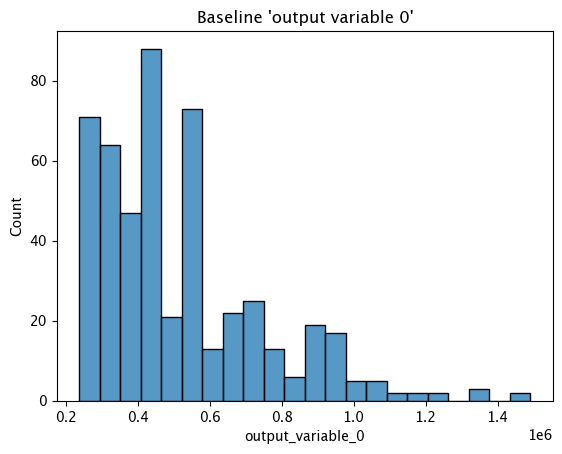

In [16]:
assay_builder_from_dates.baseline_histogram()

### Assay Preview

Now that the baseline is defined, we look at different configuration options and view how the assay baseline and results changes.  Once we determine what gives us the best method of determining model drift, we can create the assay.

The following examples show different methods of previewing the assay, then how to configure the assay by collecting data from different locations.

#### Analysis List Chart Scores

Analysis List scores show the assay scores for each assay result interval in one chart.  Values that are outside of the alert threshold are colored red, while scores within the alert threshold are green.

Assay chart scores are displayed with the method [`wallaroo.assay.AssayAnalysisList.chart_scores(title: Optional[str] = None)`](https://docs.wallaroo.ai/wallaroo-developer-guides/wallaroo-sdk-guides/wallaroo-sdk-reference-guide/assay/#AssayAnalysisList.chart_scores), with ability to display an optional title with the chart.

The following example shows retrieving the assay results and displaying the chart scores.  From our example, we have two windows - the first should be green, and the second is red showing that values were outside the alert threshold.

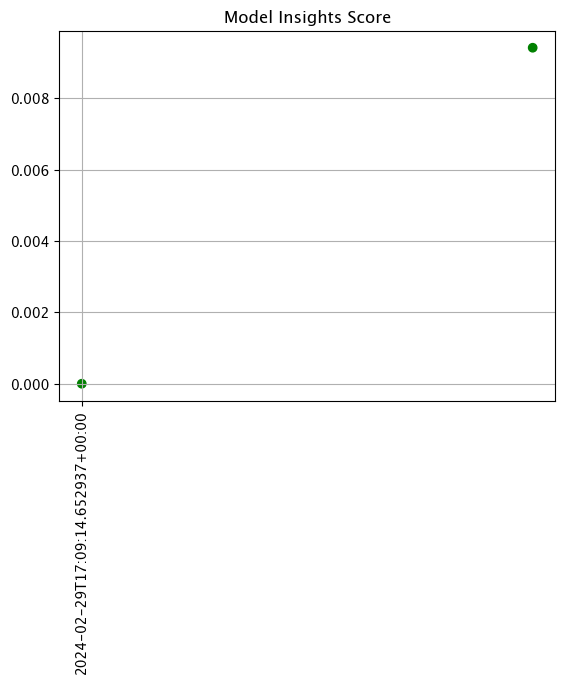

In [18]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="run anywhere from dates", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the location to use for baseline data

# set the location to the ops center
assay_builder_from_dates.window_builder().add_location_filter([location_01])
# set the width, interval, and time period 
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_baseline_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.chart_scores()

#### Analysis Chart

The method `wallaroo.assay.AssayAnalysis.chart()` displays a comparison between the baseline and an interval of inference data.

This is compared to the [Chart Scores](#analysis-list-chart-scores), which is a **list** of all of the inference data split into intervals, while the **Analysis Chart** shows the breakdown of one set of inference data against the baseline.

Score from the [Analysis List Chart Scores](#analysis-list-chart-scores) and each element from the [Analysis List DataFrame](#analysis-list-dataframe) generates 

The following fields are included.

| Field | Type | Description |
|---|---|---|
| **baseline mean** | **Float** | The mean of the baseline values. |
| **window mean** | **Float** | The mean of the window values. |
| **baseline median** | **Float** | The median of the baseline values. |
| **window median** | **Float** | The median of the window values. |
| **bin_mode** | **String** | The binning mode used for the assay. |
| **aggregation** | **String** | The aggregation mode used for the assay. |
| **metric** | **String** | The metric mode used for the assay. |
| **weighted** | **Bool** | Whether the bins were manually weighted. |
| **score** | **Float** | The score from the assay window. |
| **scores** | **List(Float)** | The score from each assay window bin. |
| **index** | **Integer/None** | The window index.  Interactive assay runs are `None`. |

baseline mean = 519540.3015625
window mean = 519540.3015625
baseline median = 450867.5625
window median = 450867.5625
bin_mode = Quantile
aggregation = Density
metric = PSI
weighted = False
score = 0.0
scores = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
index = None


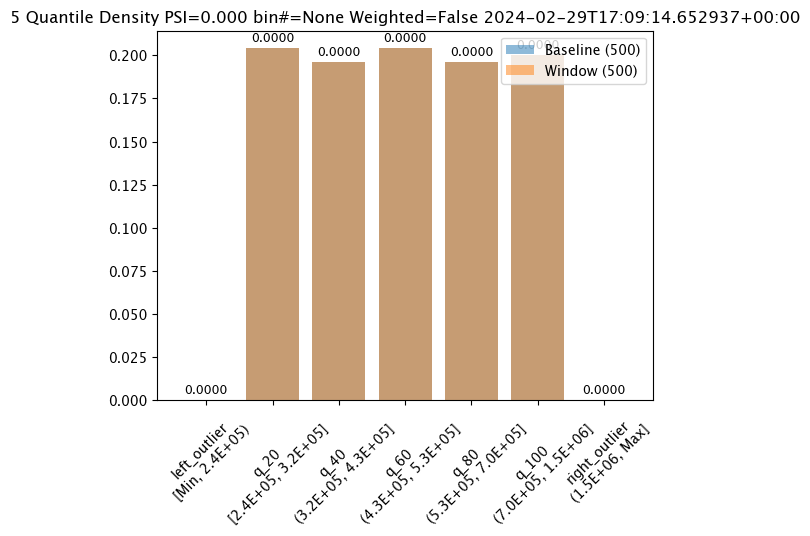

In [19]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="run anywhere from dates", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the location to use for baseline data

# set the location to the ops center
assay_builder_from_dates.window_builder().add_location_filter([location_01])
# set the width, interval, and time period 
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_baseline_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates[0].chart()

#### Analysis List DataFrame

`wallaroo.assay.AssayAnalysisList.to_dataframe()` returns a DataFrame showing the assay results for each window aka individual analysis.  This DataFrame contains the following fields:

| Field | Type | Description |
|---|---|---|
| **assay_id** | *Integer/None* | The assay id.  Only provided from uploaded and executed assays. |
| **name** | *String/None* | The name of the assay.  Only provided from uploaded and executed assays. |
| **iopath** | *String/None* | The iopath of the assay.  Only provided from uploaded and executed assays. |
| **score** | *Float* | The assay score. |
| **start** | *DateTime* | The DateTime start of the assay window.
| **min** | *Float* | The minimum value in the assay window.
| **max**  | *Float* | The maximum value in the assay window.
| **mean** | *Float* | The mean value in the assay window.
| **median** | *Float* | The median value in the assay window.
| **std** | *Float* | The standard deviation value in the assay window.
| **warning_threshold** | *Float/None* | The warning threshold of the assay window.
| **alert_threshold** | *Float/None* | The alert threshold of the assay window.
| **status** | *String* | The assay window status.  Values are:  <ul><li>`OK`: The score is within accepted thresholds.</li><li>`Warning`: The score has triggered the `warning_threshold` if exists, but not the `alert_threshold`.</li><li>`Alert`: The score has triggered the the `alert_threshold`.</li></ul> |

For this example, the assay analysis list DataFrame is listed.  

From this tutorial, we should have 2 windows of dta to look at, each one minute apart.  The first window should show `status: OK`, with the second window with the very large house prices will show `status: alert`

In [20]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="run anywhere from dates", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the location to use for baseline data

# set the location to the ops center
assay_builder_from_dates.window_builder().add_location_filter([location_01])
# set the width, interval, and time period 
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_baseline_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.to_dataframe()

,id,assay_id,assay_name,iopath,pipeline_id,pipeline_name,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,None,None,run anywhere from dates,,None,,0.000000,2024-02-29T17:09:14.652937+00:00,236238.65625,1489624.5,519540.301563,450867.5625,230723.706281,None,0.25,Ok
1,None,None,run anywhere from dates,,None,,0.009416,2024-02-29T17:10:14.652937+00:00,236238.65625,2016006.0,539489.484203,451046.9375,264051.044244,None,0.25,Ok


#### Configure Assays

Before creating the assay, **configure** the assay and continue to preview it until the best method for detecting drift is set.

##### Location Filter

This tutorial focuses on the assay configuration method `wallaroo.assay_config.WindowBuilder.add_location_filter` which takes the following parameters.

| Parameter | Type | Description |
|---|---|---|
| **locations** | List(String) | The list of model deployment locations for the assay. |

By default, the `locations` parameter includes **all locations** as part of the pipeline.  This is seen in the default where no location filter is set, and of the inference data is shown.

For our examples, we will show different locations and how the assay changes.  For the first example, we set the location to `location_01` which was used to create the baseline, and included inferences that were likely to **not** trigger a model drift detection alert.

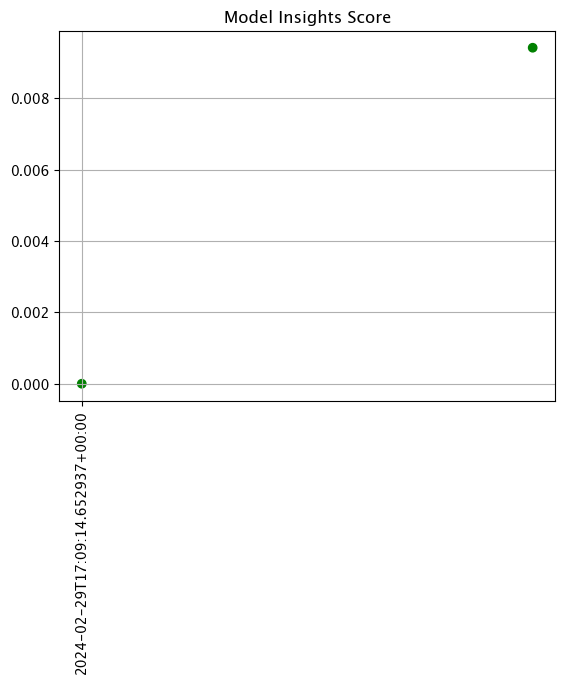

,id,assay_id,assay_name,iopath,pipeline_id,pipeline_name,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,None,None,run anywhere from dates,,None,,0.000000,2024-02-29T17:09:14.652937+00:00,236238.65625,1489624.5,519540.301563,450867.5625,230723.706281,None,0.25,Ok
1,None,None,run anywhere from dates,,None,,0.009416,2024-02-29T17:10:14.652937+00:00,236238.65625,2016006.0,539489.484203,451046.9375,264051.044244,None,0.25,Ok


In [21]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="run anywhere from dates", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the location to location_01
assay_builder_from_dates.window_builder().add_location_filter([location_01])

# set the width, interval, and time period 
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_baseline_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.chart_scores()
assay_results_from_dates.to_dataframe()

Now we will set the location to `location_02` which had a set of inferences likely to trigger a model drift alert.

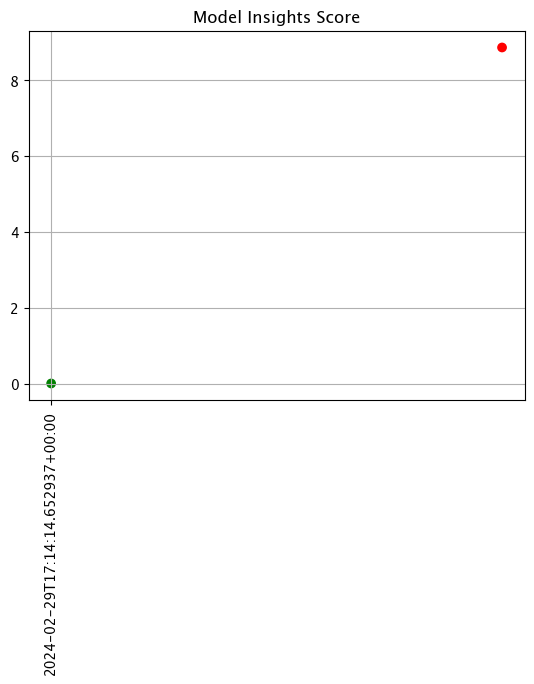

,id,assay_id,assay_name,iopath,pipeline_id,pipeline_name,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,None,None,run anywhere from dates,,None,,0.009416,2024-02-29T17:14:14.652937+00:00,2.362387e+05,2016006.0,5.394895e+05,4.510469e+05,264051.044244,None,0.25,Ok
1,None,None,run anywhere from dates,,None,,8.868647,2024-02-29T17:15:14.652937+00:00,1.514080e+06,2016006.0,1.896864e+06,1.946437e+06,147082.281289,None,0.25,Alert


In [22]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="run anywhere from dates", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

#set the location to location_02
assay_builder_from_dates.window_builder().add_location_filter([location_02])

# set the width, interval, and time period 
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_baseline_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.chart_scores()
assay_results_from_dates.to_dataframe()

The next example includes `location_01` and `location_02`.  Since they were performed in distinct times, the model insights scores for each location is seen in the chart.

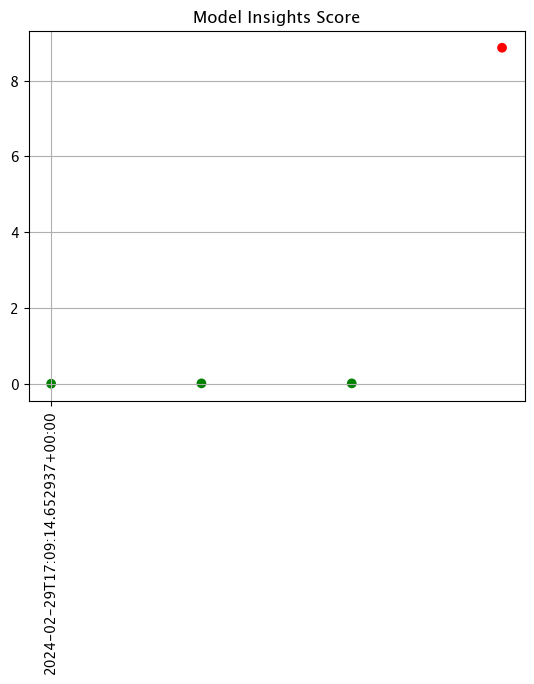

,id,assay_id,assay_name,iopath,pipeline_id,pipeline_name,score,start,min,max,mean,median,std,warning_threshold,alert_threshold,status
0,None,None,run anywhere from dates,,None,,0.000000,2024-02-29T17:09:14.652937+00:00,2.362387e+05,1489624.5,5.195403e+05,4.508676e+05,230723.706281,None,0.25,Ok
1,None,None,run anywhere from dates,,None,,0.009416,2024-02-29T17:10:14.652937+00:00,2.362387e+05,2016006.0,5.394895e+05,4.510469e+05,264051.044244,None,0.25,Ok
2,None,None,run anywhere from dates,,None,,0.009416,2024-02-29T17:14:14.652937+00:00,2.362387e+05,2016006.0,5.394895e+05,4.510469e+05,264051.044244,None,0.25,Ok
3,None,None,run anywhere from dates,,None,,8.868647,2024-02-29T17:15:14.652937+00:00,1.514080e+06,2016006.0,1.896864e+06,1.946437e+06,147082.281289,None,0.25,Alert


In [23]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="run anywhere from dates", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the location to both location_01 and location_02
assay_builder_from_dates.window_builder().add_location_filter([location_01, location_02])


# set the width, interval, and time period
assay_builder_from_dates.add_run_until(datetime.datetime.now())
assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_baseline_start)
assay_config_from_dates = assay_builder_from_dates.build()
assay_results_from_dates = assay_config_from_dates.interactive_run()

assay_results_from_dates.chart_scores()
assay_results_from_dates.to_dataframe()

### Create Assay

With the assay previewed and configuration options determined, we officially create it by uploading it to the Wallaroo instance.

Once it is uploaded, the assay runs an analysis based on the window width, interval, and the other settings configured.

Assays are uploaded with the `wallaroo.assay_config.upload()` method. This uploads the assay into the Wallaroo database with the configurations applied and returns the assay id. Note that assay names **must be unique across the Wallaroo instance**; attempting to upload an assay with the same name as an existing one will return an error.

`wallaroo.assay_config.upload()` returns the assay id for the assay.

Typically we would just call `wallaroo.assay_config.upload()` after configuring the assay.  For the example below, we will perform the complete configuration in one window to show all of the configuration steps at once before creating the assay, and narrow the locations to `location_01` and `location_02`.  By default, **all** locations associated with a pipeline are included in the assay results unless the `add_location_filter` method is applied to specify location(s).

In [24]:
# Build the assay, based on the start and end of our baseline time, 
# and tracking the output variable index 0
assay_builder_from_dates = wl.build_assay(assay_name="run anywhere from dates example", 
                                          pipeline=mainpipeline, 
                                          model_name="house-price-estimator", 
                                          iopath="output variable 0",
                                          baseline_start=assay_baseline_start, 
                                          baseline_end=assay_baseline_end)

# set the location to both the edge locations
assay_builder_from_dates.window_builder().add_location_filter([location_01, location_02])

assay_builder_from_dates.window_builder().add_width(minutes=1).add_interval(minutes=1).add_start(assay_baseline_start)


assay_id = assay_builder_from_dates.upload()


The assay is now visible through the Wallaroo UI by selecting the workspace, then the pipeline, then **Insights**.  The following is an example of another assay in the Wallaroo Dashboard.

![Sample assay in the UI](images/housepricesaga-sample-assay.png)

### Get Assay Results

Once an assay is created the assay runs an analysis based on the window width, interval, and the other settings configured.

Assay results are retrieved with the `wallaroo.client.get_assay_results` method, which takes the following parameters:

| Parameter | Type | Description |
|---|---|---|
| **assay_id** | *Integer* (*Required*) | The numerical id of the assay. |
| **start** | *Datetime.Datetime* (*Required*) | The start date and time of historical data from the pipeline to start analyses from. |
| **end** | *Datetime.Datetime* (*Required*) | The end date and time of historical data from the pipeline to limit analyses to. |

* **IMPORTANT NOTE**:  This process requires that additional historical data is generated from the time the assay is created to when the results are available. To add additional inference data, use the [Assay Test Data](#assay-test-data) section above.

In [26]:
assay_results = wl.get_assay_results(assay_id=assay_id,
                     start=assay_baseline_start,
                     end=datetime.datetime.now())

display(assay_results.chart_scores())

ValueError: No data in this AssayAnalysisList.

In [ ]:
assay_results[0].chart()